# Pycorrelate examples and validation

This notebook show `pycorrelate` usage as well comparisons with other 
less efficient implementations.

In [1]:
import numpy as np
import h5py

In [2]:
# Tweak here matplotlib style
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
mpl.rcParams['font.size'] = 14
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
import pycorrelate as pyc

## Generate some data

In [104]:
np.random.seed(1)
size = 10**4
t = np.sort(np.random.randint(0, 10**5, size=size))
u = np.sort(t + np.random.exponential(scale=10, size=t.size).astype(np.int64))
#t.sort()
#u.sort()
#t = np.unique(t)
#u = np.unique(u)

In [105]:
np.unique(t).size

9553

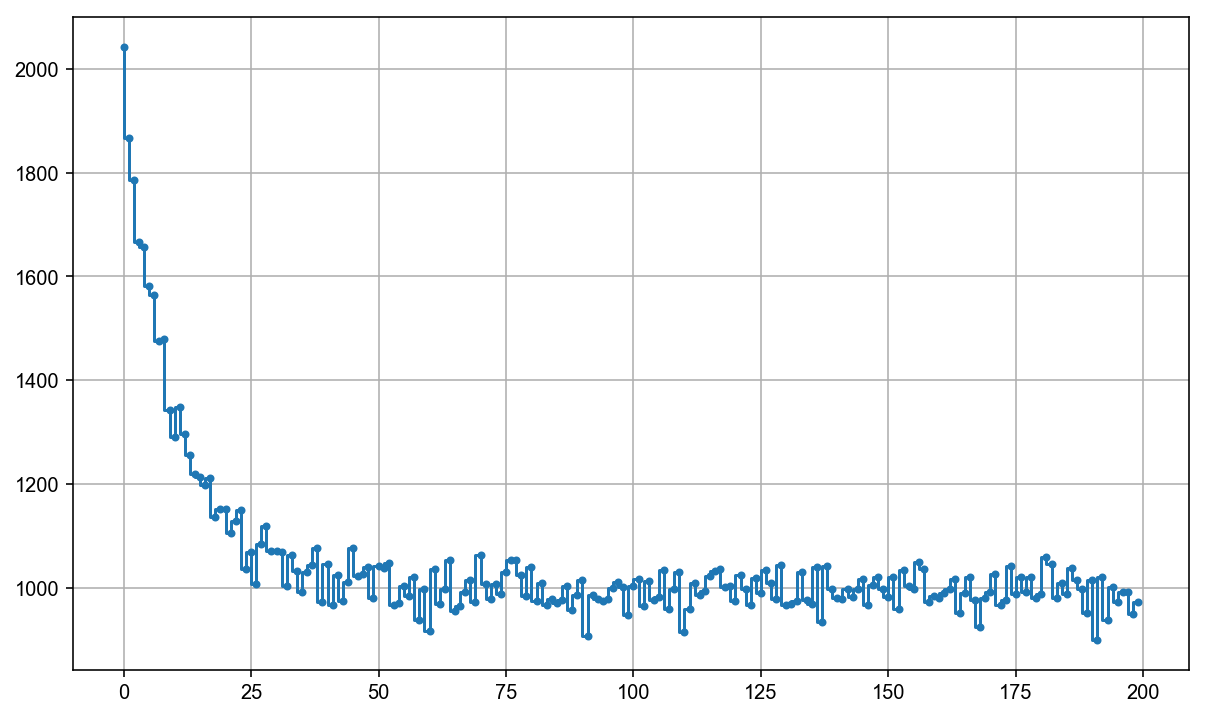

In [106]:
assert (np.diff(t) >= 0).all()
assert (np.diff(u) >= 0).all()

nbins = 200
bins = np.arange(0, nbins + 1)
G = pyc.pcorrelate(t, u, bins).astype('int64')

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(G, drawstyle='steps-pre', marker='o', ms=3)
plt.grid(True); plt.grid(True, which='minor', lw=0.3)

In [107]:
tx, _ = np.histogram(t, bins=np.arange(size*10+1))
ux, _ = np.histogram(u, bins=np.arange(size*10+1))

In [108]:
Gu = pyc.ucorrelate(tx, ux, maxlags=nbins)

In [109]:
Gu.size == G.size

True

In [110]:
np.unique(G - Gu)

array([0, 1, 2, 3])

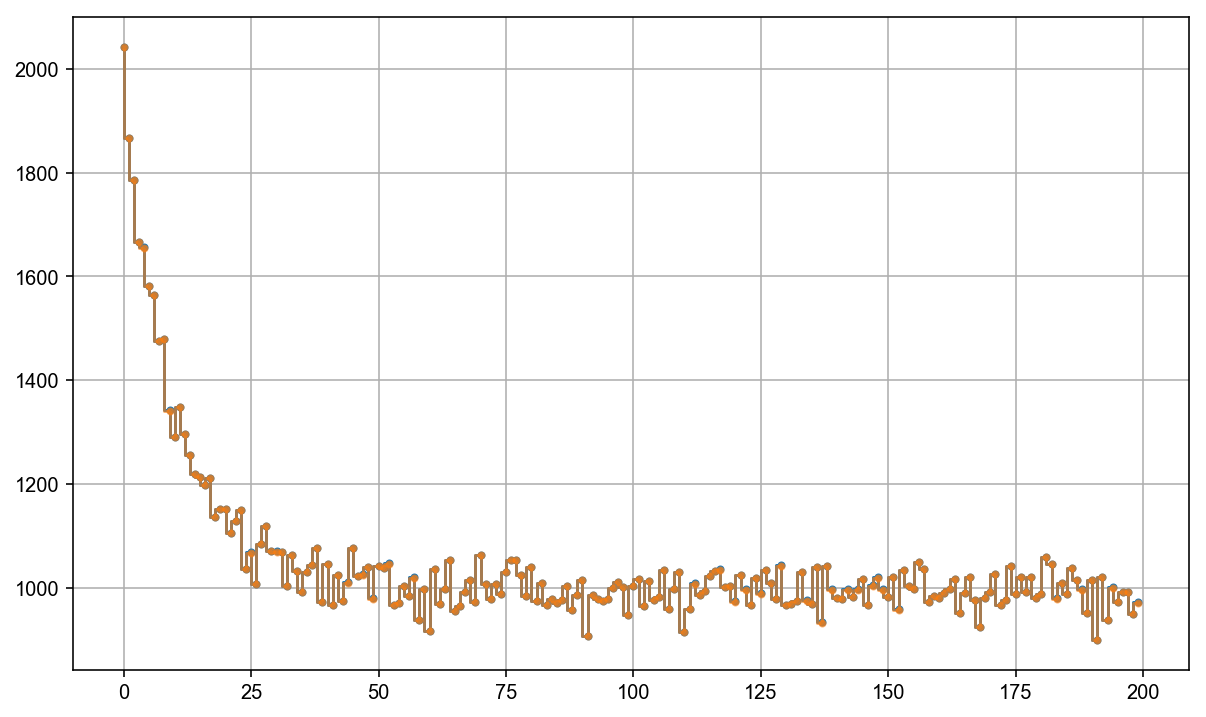

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(G, drawstyle='steps-pre', marker='o', ms=3)
plt.plot(Gu, drawstyle='steps-pre', marker='o', ms=3, alpha=0.6)
plt.grid(True); plt.grid(True, which='minor', lw=0.3)

## Test: comparison with np.histogram

For testing we use smaller input arrays:

In [100]:
Y = np.zeros(nbins, dtype=np.int64)
for ti in t:
    Yc, _ = np.histogram(u - ti+0.01, bins=bins)
    Y += Yc
Gh = Y / np.diff(bins)

In [101]:
assert (G[:-1] == Gh[:-1]).all()

In [97]:
G[-1], Gh[-1]

(895, 901.0)

Test passed! Here we demonstrated that the logic of the algorithm
is implemented as described in the paper (and in the few lines of code above).

## Tests: comparison with np.correlate

The comparison with `np.correlate` is a little tricky.
First we need to bin our input to create timetraces that can be correlated
by linear convolution. For testing purposes, let's choice
some timetrace bins:

The plots above are the two curves we are going to feed to
`np.correlate`:

In [72]:
C = np.correlate(ux, tx, mode='full')

We need to trim the result to obtain a proper alignment with
the 0-time lag:

In [73]:
Gn = C[tx.size-1:]  # trim to positive time lags

Now, we can check that both `numpy.correlate` and `pycorrelate.ucorrelate`
give the same result:

In [74]:
Gu = pyc.ucorrelate(tx, ux)
assert (Gu == Gn).all()

In [75]:
G - Gu[:nbins]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

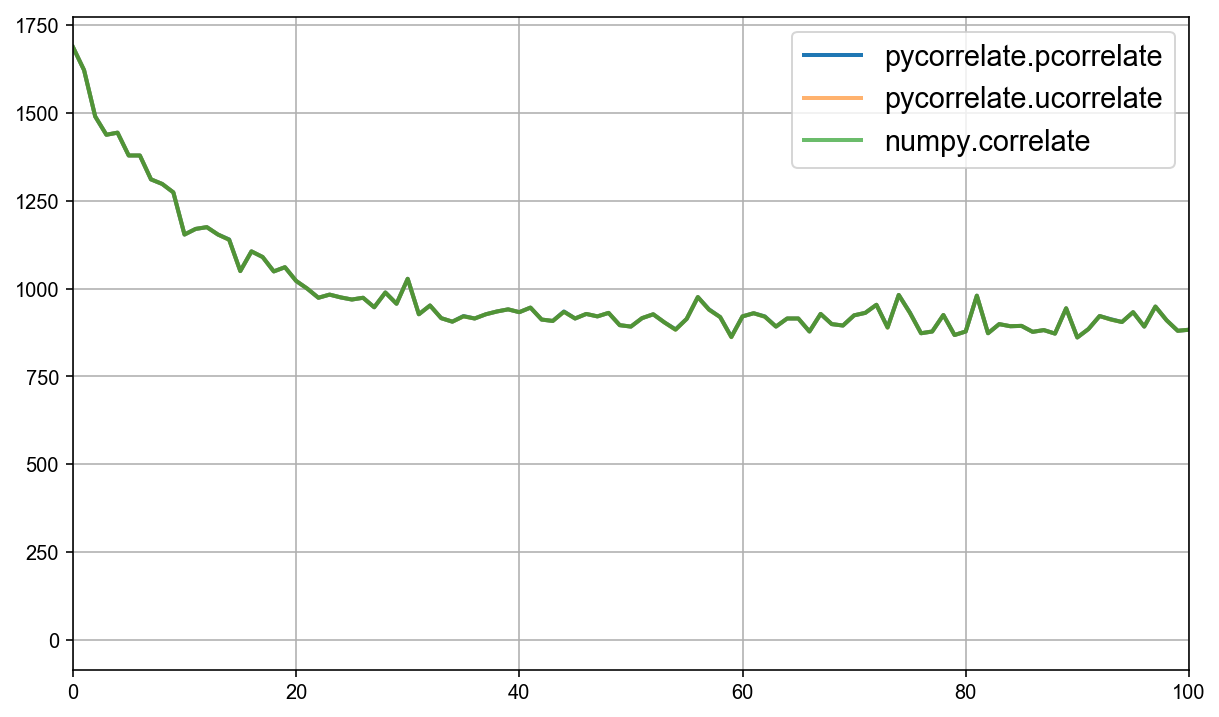

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(G, alpha=1, lw=2, label='pycorrelate.pcorrelate') 
plt.plot(Gu, alpha=0.6, lw=2, label='pycorrelate.ucorrelate')
plt.plot(Gn, alpha=0.7, lw=2, label='numpy.correlate')
plt.grid(True)
plt.xlim(0, 100)
#plt.xscale('log') 
plt.legend(loc='best', fontsize='x-large');

- There is a difference between numpy.correlate/pyc.ucorrelate and pyc.pcorrelate
- With unique timestamps (no repetition the difference seems limited to 1.